**Interpolation and Extrapolation**

In [122]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [123]:
#Creating the data (Sin values)
N = 1000
x = torch.linspace(0,N-1,steps=N)
data = torch.sin(2*np.pi*x/50)

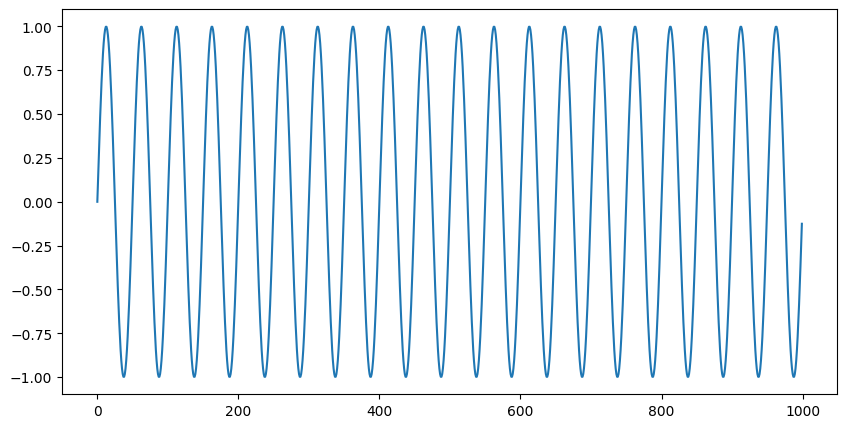

In [124]:
plt.figure(figsize=(10,5))
plt.plot(data)

In [125]:
print(data.shape)

torch.Size([1000])


In [126]:
#Create the LSTM model
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_layer_size,output_size):
    super().__init__()

    #Define the parameters
    self.input_size = input_size
    self.hidden_layer_size = hidden_layer_size
    self.output_size = output_size

    #LSTM Layer
    self.lstm = nn.LSTM(input_size,hidden_layer_size)

    #Output Layer
    self.out = nn.Linear(hidden_layer_size,1)

  def forward(self,x):

    y, (h,c)= self.lstm(x)
    out = self.out(y)

    return out,(h,c)

In [127]:
#Setting the parameters

input_size = 1 #D
hidden_size = 50
output_size = 1
seqlength = 50 #T

In [128]:
#Create model instance, and set the loss function and the optimiser
model = LSTM(input_size,hidden_size,output_size)
lossfunc = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)

model

LSTM(
  (lstm): LSTM(1, 50)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [129]:
i =0
X = data[i:i+seqlength]
y = data[i+seqlength]
print(X.shape)

torch.Size([50])


In [130]:
#Train the model

epochs = 50
losses = np.zeros(epochs)

for epoch in range(epochs):
  batchloss = []
  for i in range(N-seqlength):
    X = data[i:i+seqlength].view(seqlength,1,1) # seqlength * batchlength * input size
    y = data[i+seqlength].view(1,1)

    ypred, (h,c) = model(X)
    loss = lossfunc(ypred,y)
    batchloss.append(loss.item())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  losses[epoch] = np.mean(batchloss)
  if(epoch%10==0):
    print('Epoch:',epoch,'Loss:',losses[epoch])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([50, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.5181121870310285
Epoch: 10 Loss: 0.03573483102372847
Epoch: 20 Loss: 0.006069180796870282
Epoch: 30 Loss: 0.002227222459305746
Epoch: 40 Loss: 0.0012234128403552428


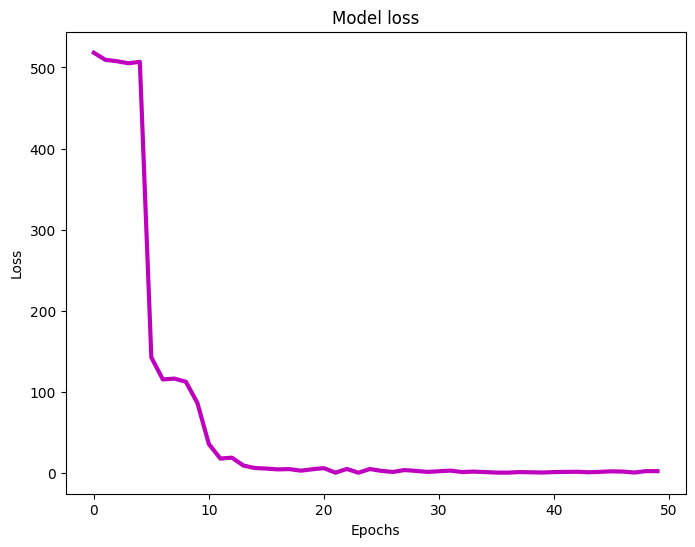

In [131]:
#Visualising the performance
plt.figure(figsize = (8,6))
plt.plot(1000 * losses,'m', lw = 3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

In [132]:
#Testing the network (Interpolation - Can be used to fill in the missing values)
yt = np.zeros(N)
for i in range(N-seqlength):
  Xt = data[i:i+seqlength].view(seqlength,1,1)

  yt_pred, (h_t,c_t) = model(Xt)
  yt[i+seqlength] = yt_pred[-1]

<ipython-input-133-faafed8930f3>:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1].plot(data-yt,'m')


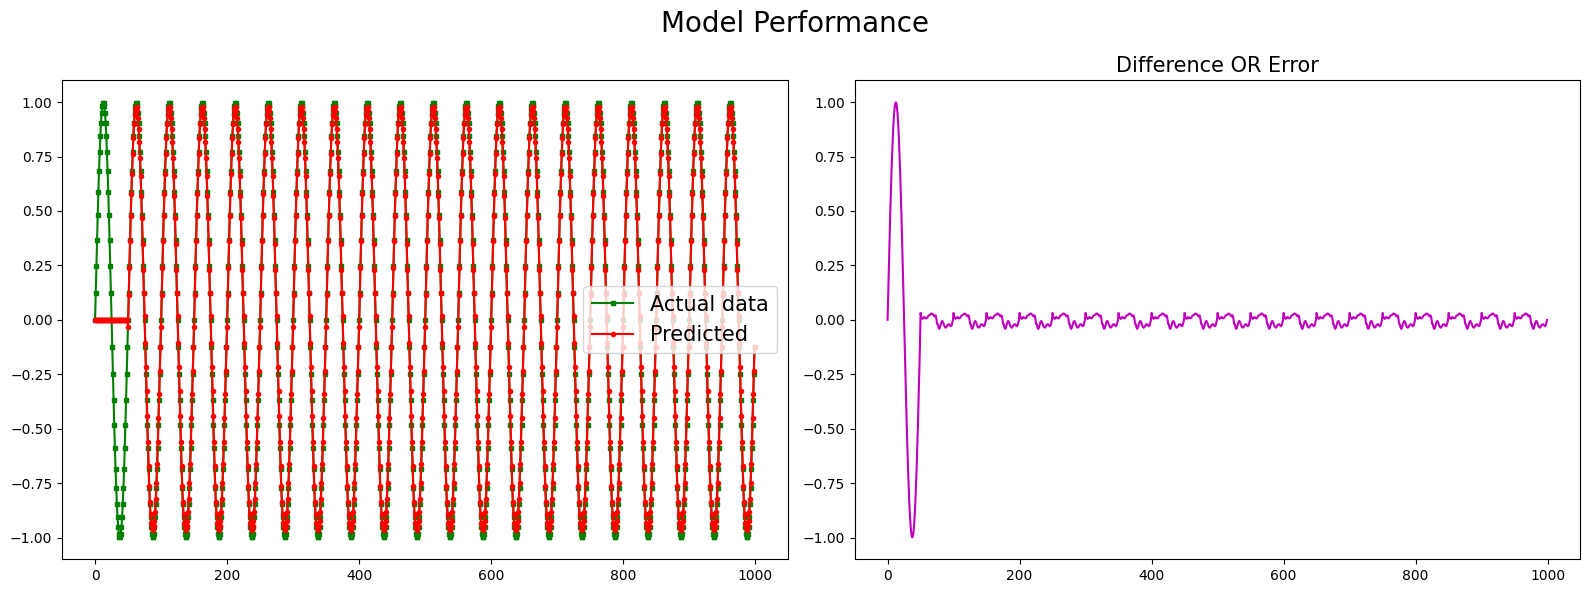

In [133]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(data,'gs-',label='Actual data',markersize=3)
ax[0].plot(yt,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend(fontsize = 15)

ax[1].plot(data-yt,'m')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Difference OR Error', fontsize = 15)


plt.suptitle('Model Performance', fontsize = 20)
plt.tight_layout()
plt.show()

<ipython-input-134-15b7620b15cd>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1].plot(data-yt,'m')


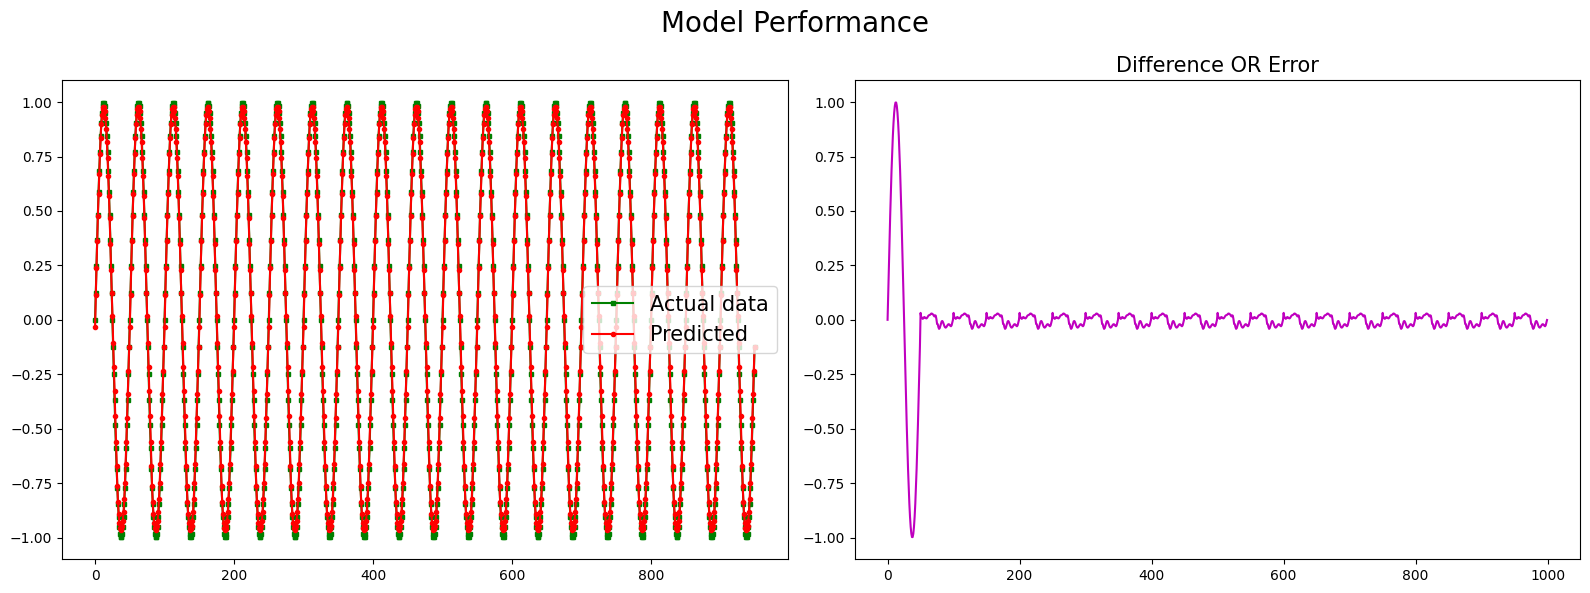

In [134]:
#Deleting the first 50 samples from data and predicted data to observe the interpolation
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(data[seqlength:],'gs-',label='Actual data',markersize=3)
ax[0].plot(yt[seqlength:],'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend(fontsize = 15)

ax[1].plot(data-yt,'m')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Difference OR Error', fontsize = 15)


plt.suptitle('Model Performance', fontsize = 20)
plt.tight_layout()
plt.show()

 Iteration 155/1950


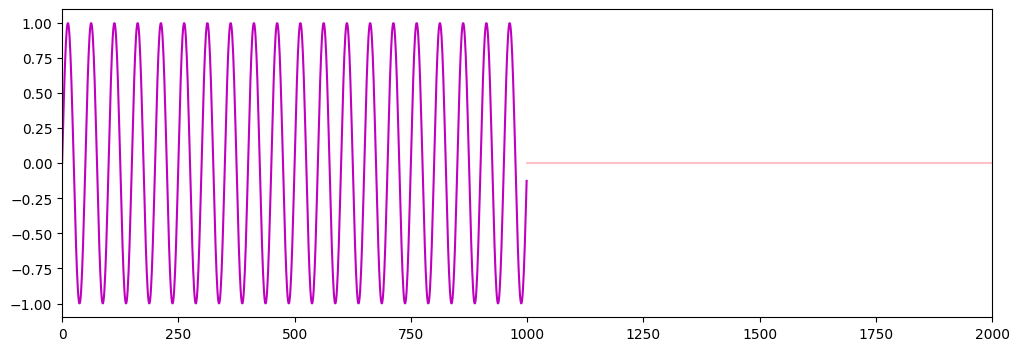

 Iteration 311/1950


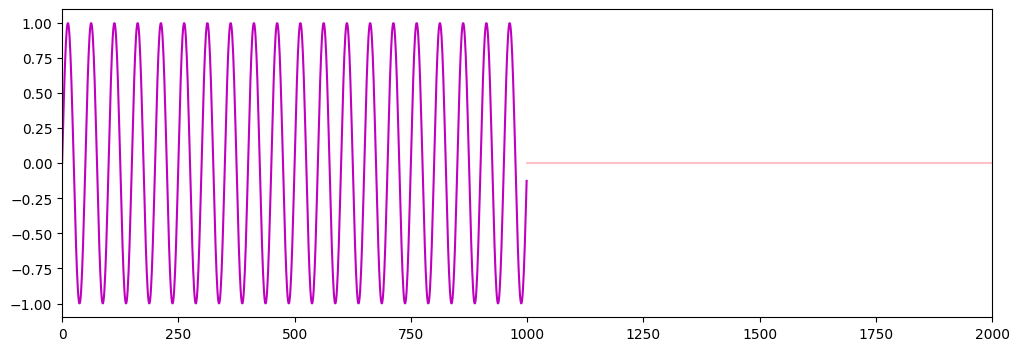

 Iteration 467/1950


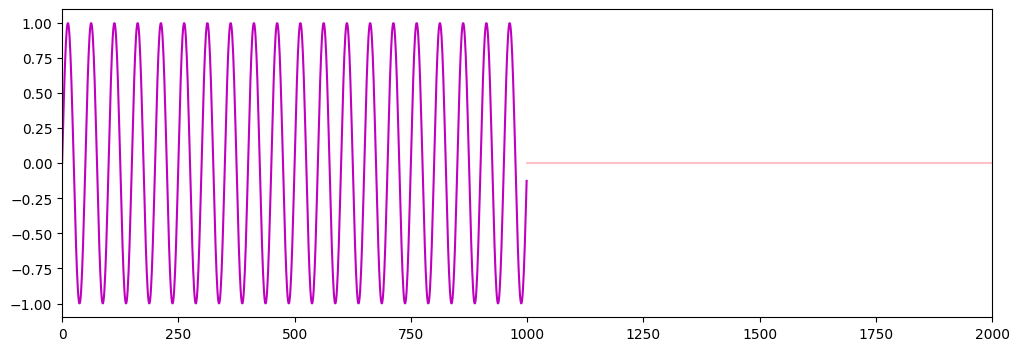

 Iteration 623/1950


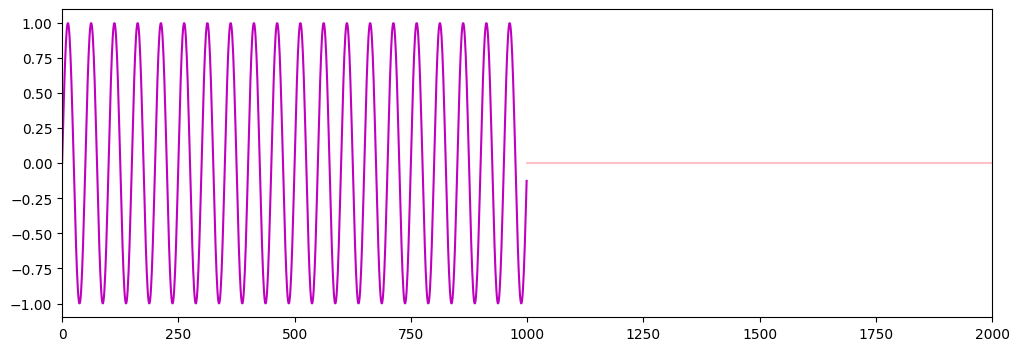

 Iteration 779/1950


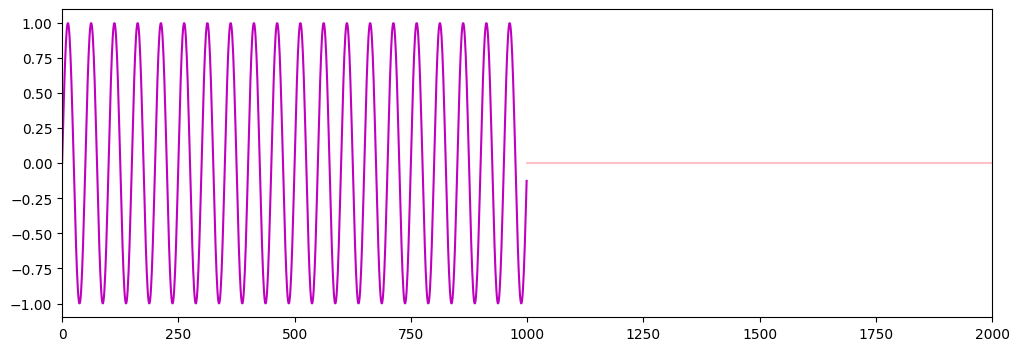

 Iteration 935/1950


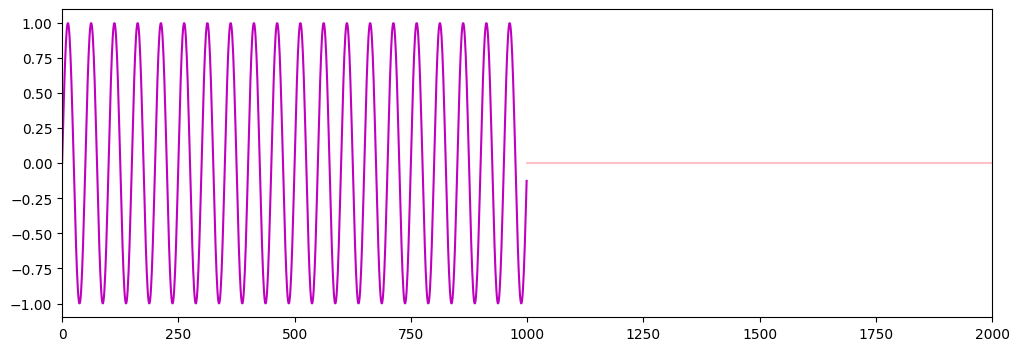

 Iteration 1091/1950


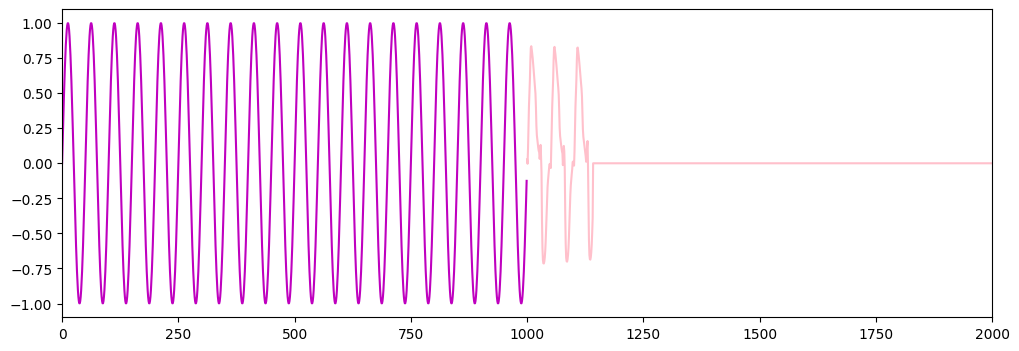

 Iteration 1247/1950


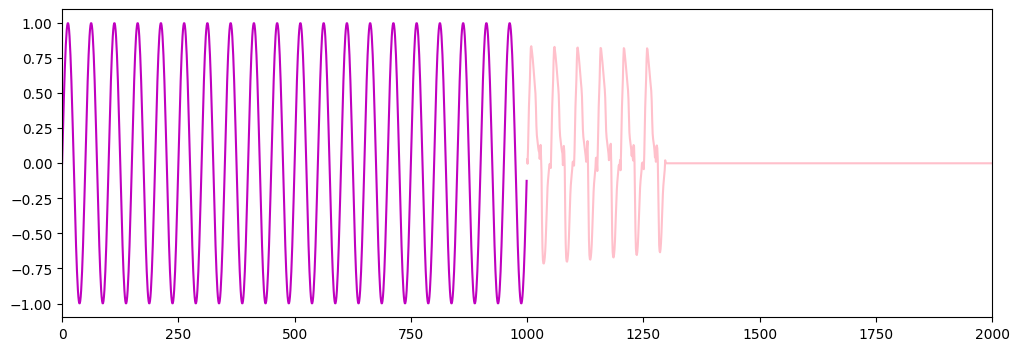

 Iteration 1403/1950


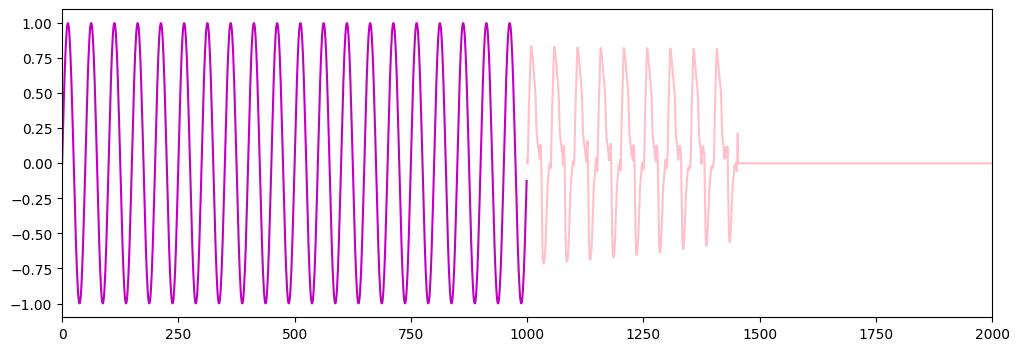

 Iteration 1559/1950


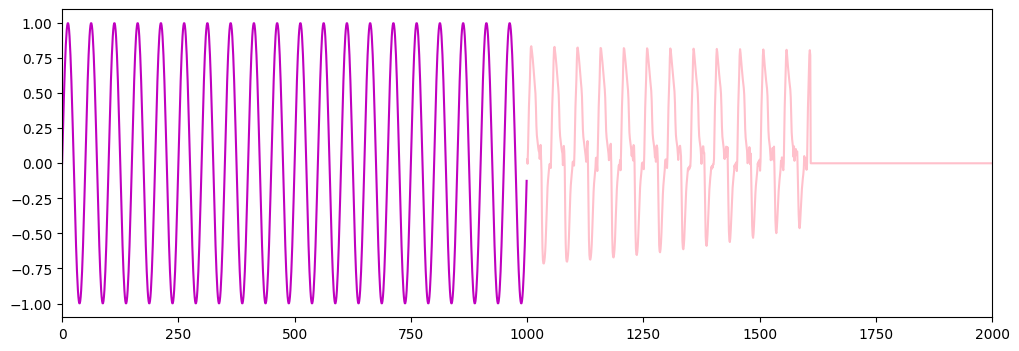

 Iteration 1715/1950


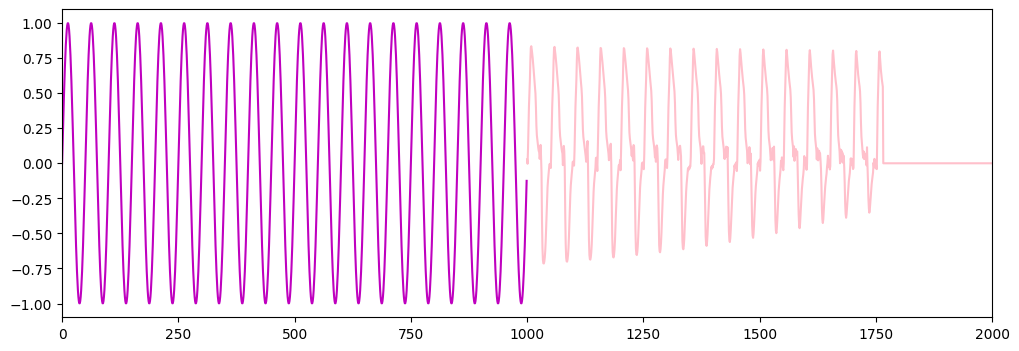

 Iteration 1871/1950


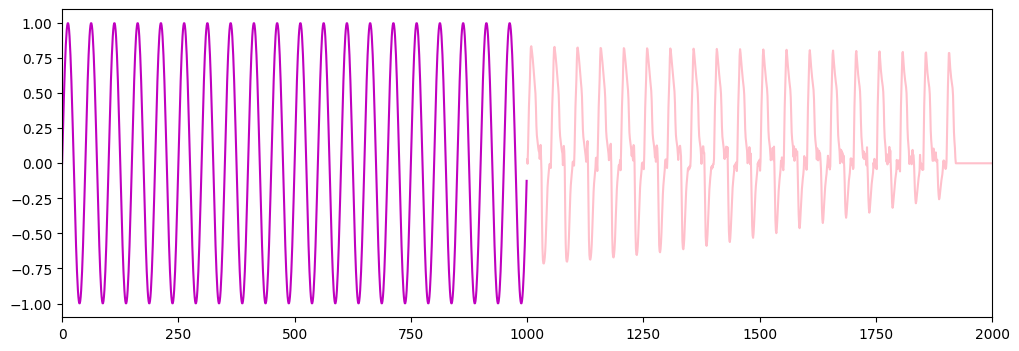

In [135]:
#Extrapolation

seqlength = 50

# Create a data which is two times longer than the original data to perform extrapolation

yt = torch.zeros(2*N)  #  2*N = 2000
yt[:N] = data

for i in range(2*N-seqlength):

  X = yt[i:i+seqlength].view(seqlength,1,1)

  yt_pred, (h_t, c_t) = model(X)
  yt[i+seqlength] = yt_pred[-1]

  if ((i + 1) % 156) == 0.0:
      print(f' Iteration {i}/{2*N-seqlength}')
      plt.figure(figsize=(12,4))
      plt.xlim(0,2*N)
      plt.plot(data.numpy(),'m')
      plt.plot(range(N,2*N),yt.detach().numpy()[N:], 'pink')
      plt.show()